In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

##### bicycle_train.csv : 학습 데이터
##### date_time : 일별 날짜
##### wind_direction: 풍향 (degree)
##### sky_condition : 하늘 상태 (하단 설명 참조)
##### precipitation_form : 강수 형태 (하단 설명 참조)
##### wind_speed : 풍속 (m/s)
##### humidity : 습도 (%)
##### low_temp : 최저 기온 ( `C)
##### high_temp : 최고 기온 ( `C)
##### Precipitation_Probability : 강수 확률 (%)
##### number_of_rentals : 따릉이 대여량

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  273 non-null    object 
 1   wind_direction             273 non-null    float64
 2   sky_condition              273 non-null    float64
 3   precipitation_form         273 non-null    float64
 4   wind_speed                 273 non-null    float64
 5   humidity                   273 non-null    float64
 6   low_temp                   273 non-null    float64
 7   high_temp                  273 non-null    float64
 8   Precipitation_Probability  273 non-null    float64
 9   number_of_rentals          273 non-null    int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 21.5+ KB


In [4]:
train_df['date_time'] = pd.to_datetime(train_df['date_time'])

## Data EDA

In [5]:
import seaborn as sns

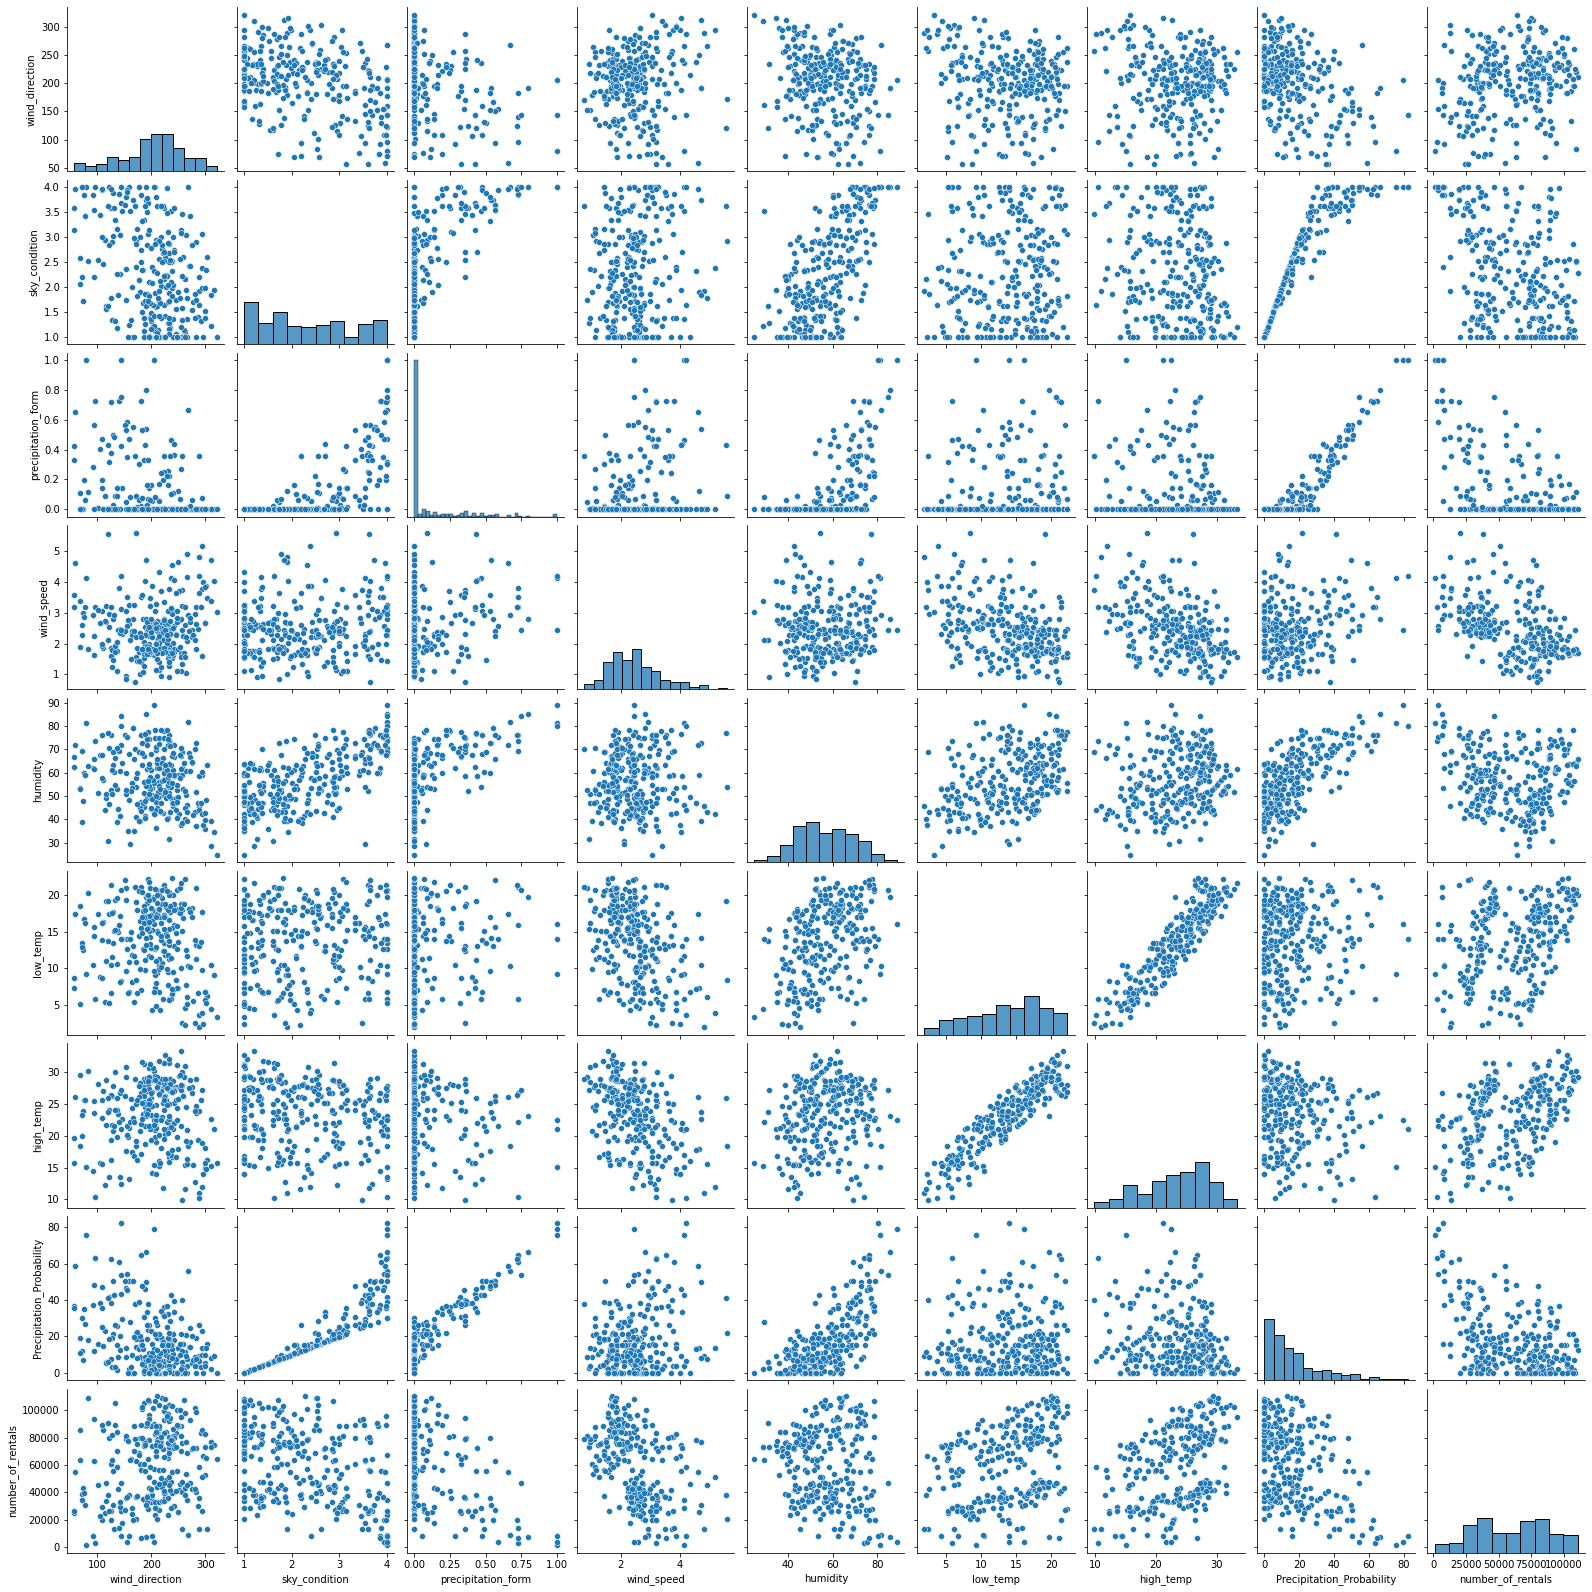

In [6]:
sns.pairplot(train_df)

<AxesSubplot:xlabel='wind_direction', ylabel='number_of_rentals'>

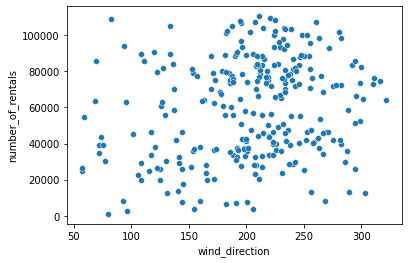

In [7]:
sns.scatterplot(x = train_df['wind_direction'], y = train_df['number_of_rentals'])

<AxesSubplot:xlabel='sky_condition', ylabel='number_of_rentals'>

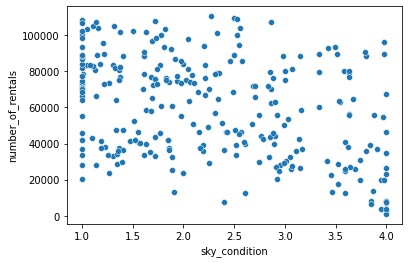

In [8]:
sns.scatterplot(x = train_df['sky_condition'], y = train_df['number_of_rentals'])

<AxesSubplot:xlabel='humidity', ylabel='number_of_rentals'>

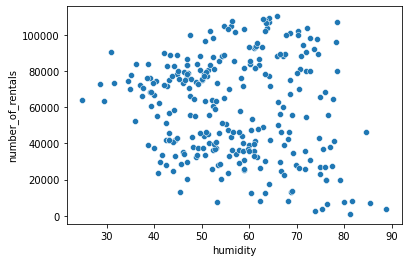

In [9]:
sns.scatterplot(x = train_df['humidity'], y = train_df['number_of_rentals'])

#### Wind Condition, Sky Condition, humidity는 큰 연관성이 없어 보임

In [10]:
train_df['year'] = train_df['date_time'].dt.year
train_df['month'] = train_df['date_time'].dt.month
train_df['day'] = train_df['date_time'].dt.day
train_df['dayofweek'] = train_df.date_time.dt.dayofweek

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 [Text(-1.0, 0, '(2020, 6)'),
  Text(0.0, 0, '(2018, 4)'),
  Text(1.0, 0, '(2018, 5)'),
  Text(2.0, 0, '(2018, 6)'),
  Text(3.0, 0, '(2019, 4)'),
  Text(4.0, 0, '(2019, 5)'),
  Text(5.0, 0, '(2019, 6)'),
  Text(6.0, 0, '(2020, 4)'),
  Text(7.0, 0, '(2020, 5)'),
  Text(8.0, 0, '(2020, 6)'),
  Text(9.0, 0, '')])

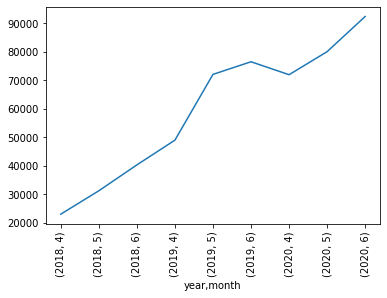

In [11]:
train_df.groupby(['year','month'])['number_of_rentals'].mean().plot()
plt.xticks(rotation = 90)

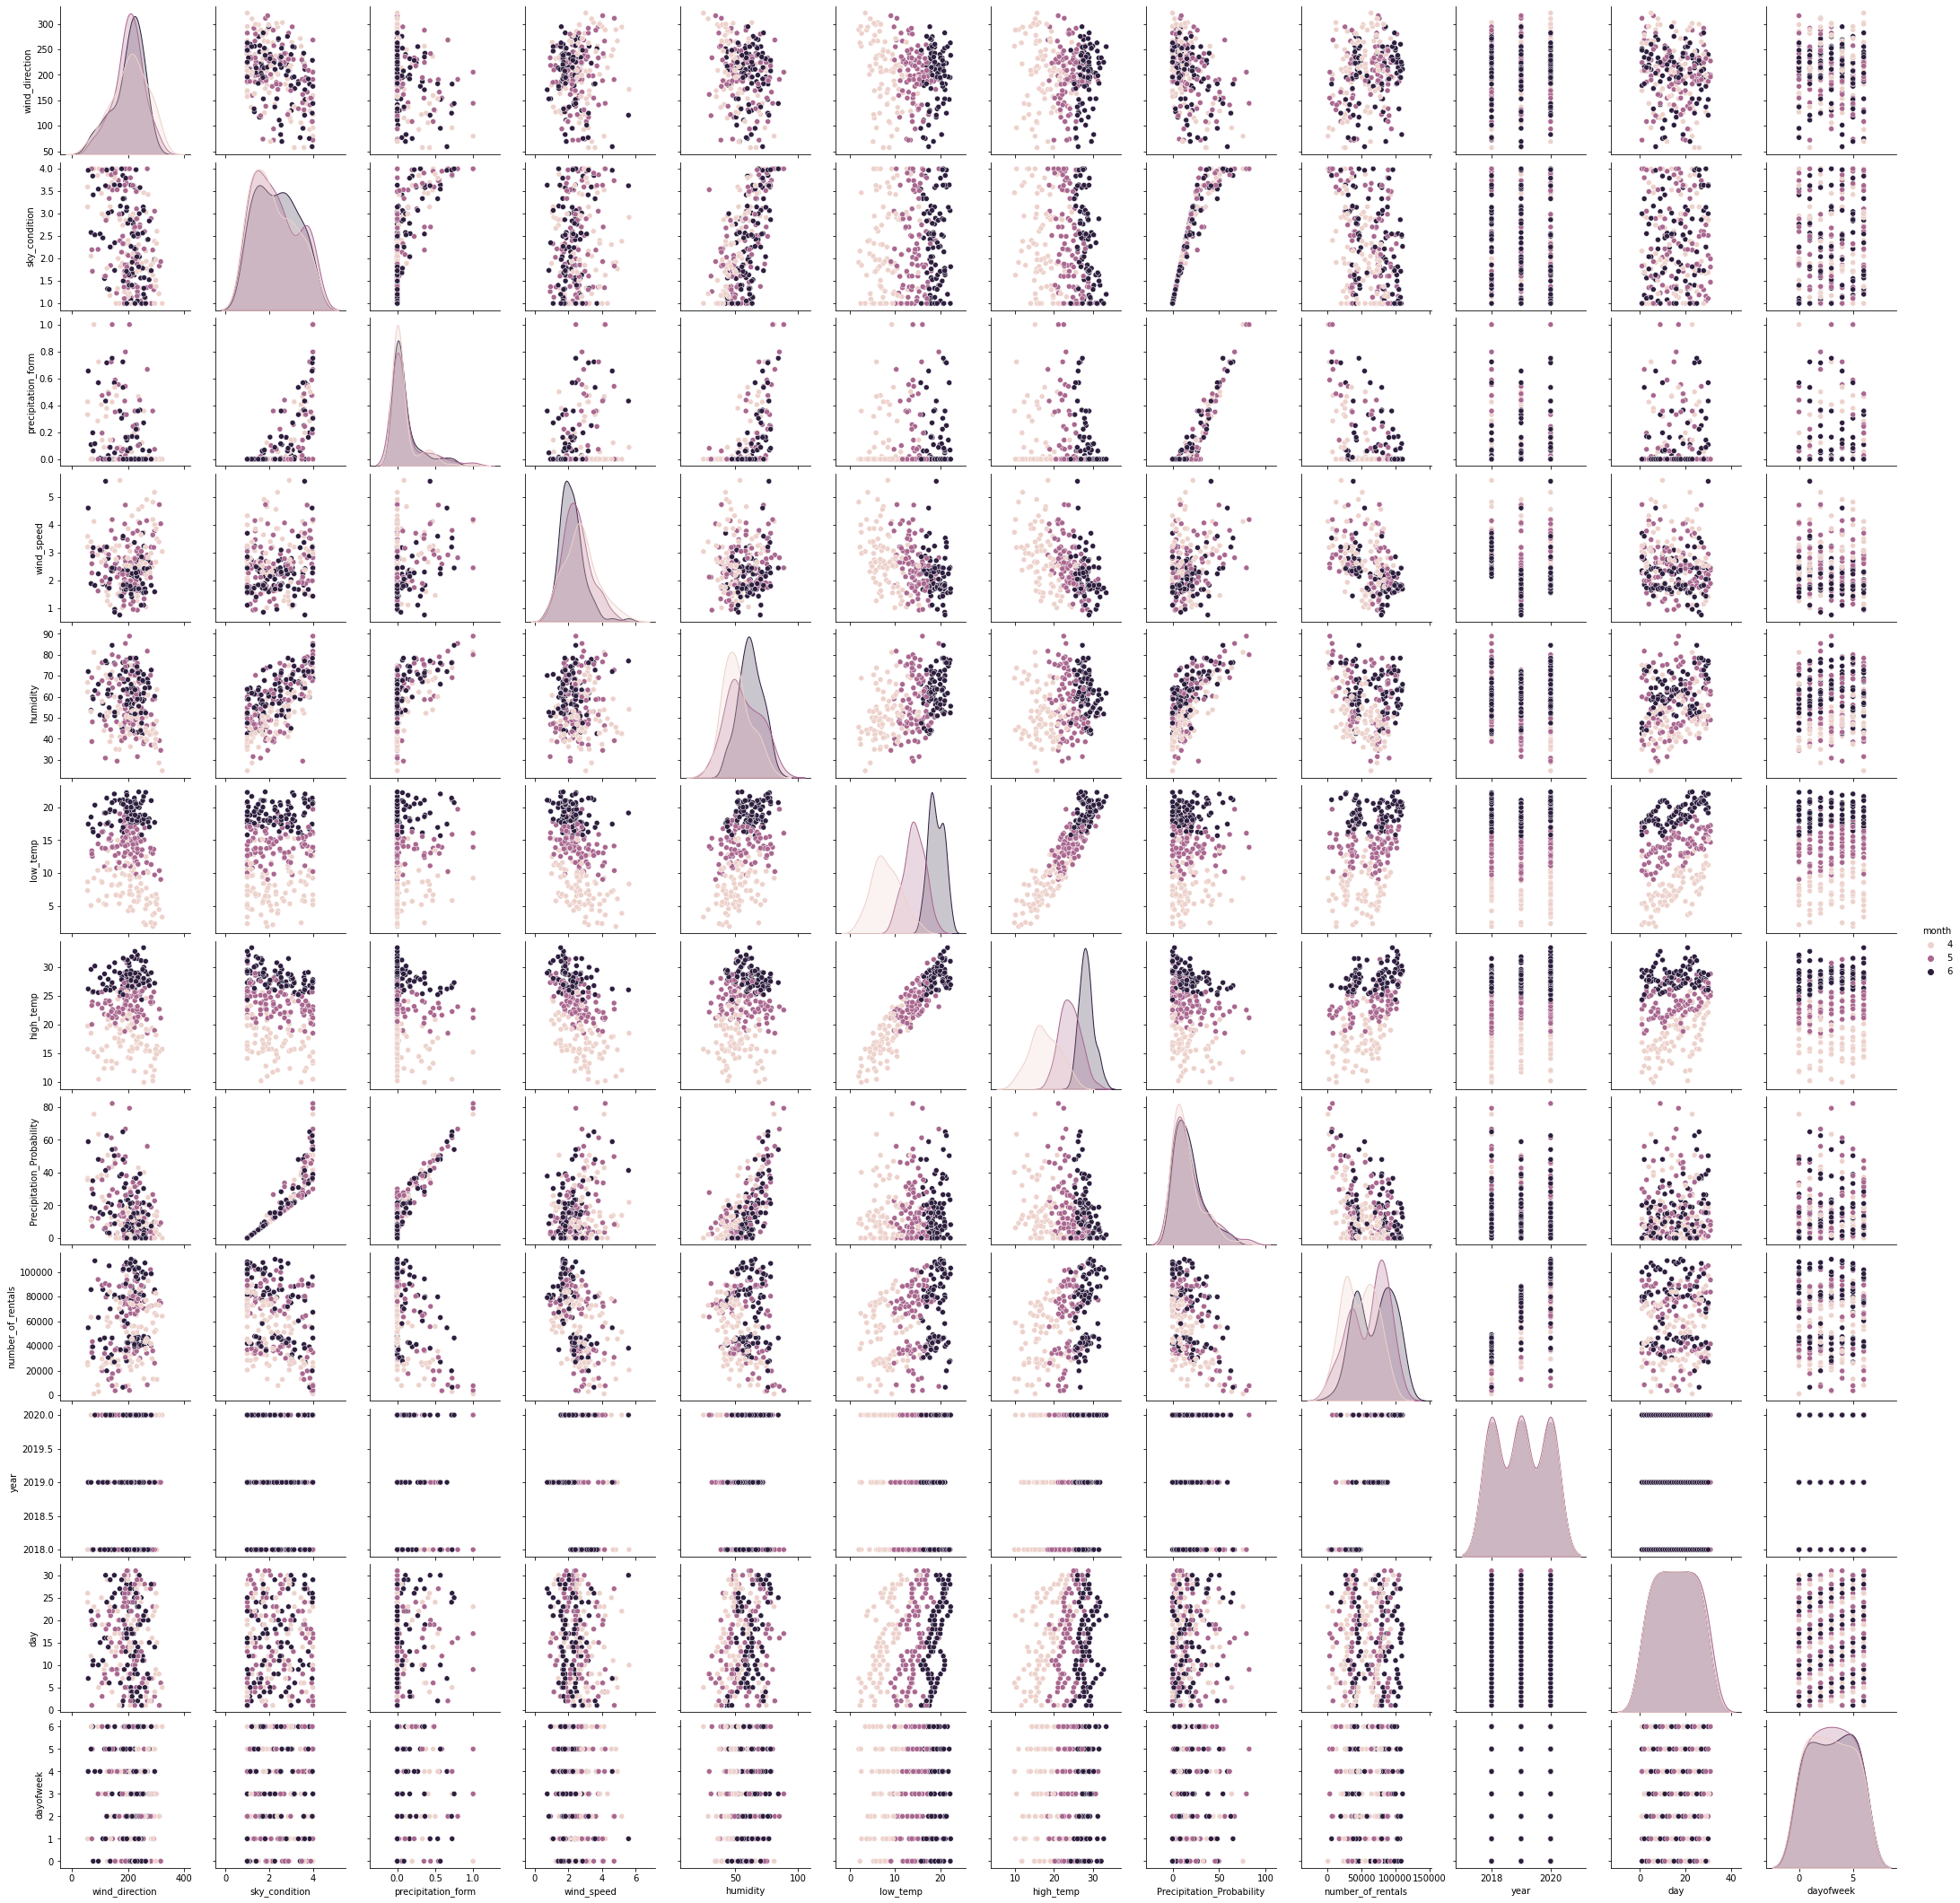

In [12]:
sns.pairplot(train_df, hue = 'month')

<AxesSubplot:xlabel='precipitation_form', ylabel='number_of_rentals'>

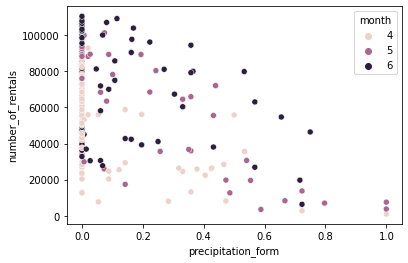

In [13]:
sns.scatterplot(x = train_df['precipitation_form'], y = train_df['number_of_rentals'], hue = train_df['month'])

In [14]:
train_df_num = train_df.select_dtypes(np.number)

<AxesSubplot:>

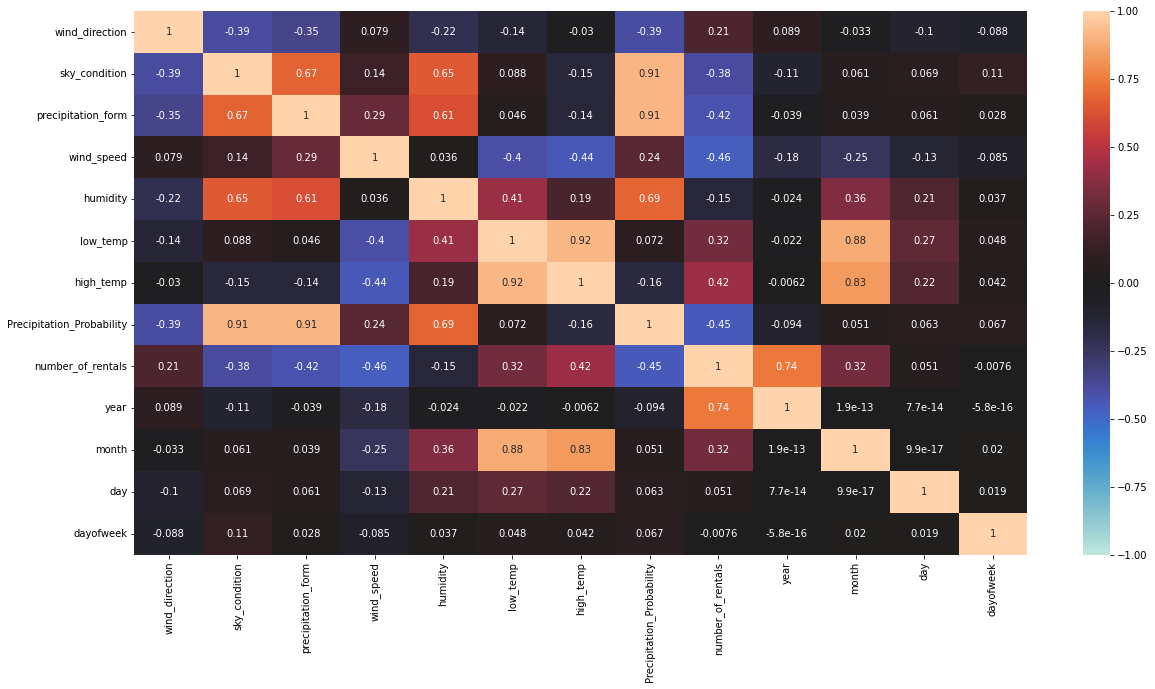

In [15]:
corr = train_df_num.corr()
plt.figure(figsize = (20, 10))
sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, annot=True)

precipitation_form, wind_speedm high_temp, precipitation_probability, year

불쾌지수=1.8x기온–0.55x(1–습도)x(1.8x기온–26)+32

In [16]:
train_df['Discomfort index'] = 1.8 * train_df['high_temp'] - 0.55 * (1 - train_df['humidity'] / 100) * (1.8 * train_df['high_temp'] - 26) + 32

<AxesSubplot:xlabel='Discomfort index', ylabel='number_of_rentals'>

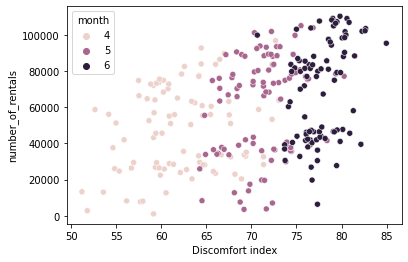

In [17]:
sns.scatterplot(x = train_df['Discomfort index'], y = train_df['number_of_rentals'], hue = train_df['month'])

<AxesSubplot:>

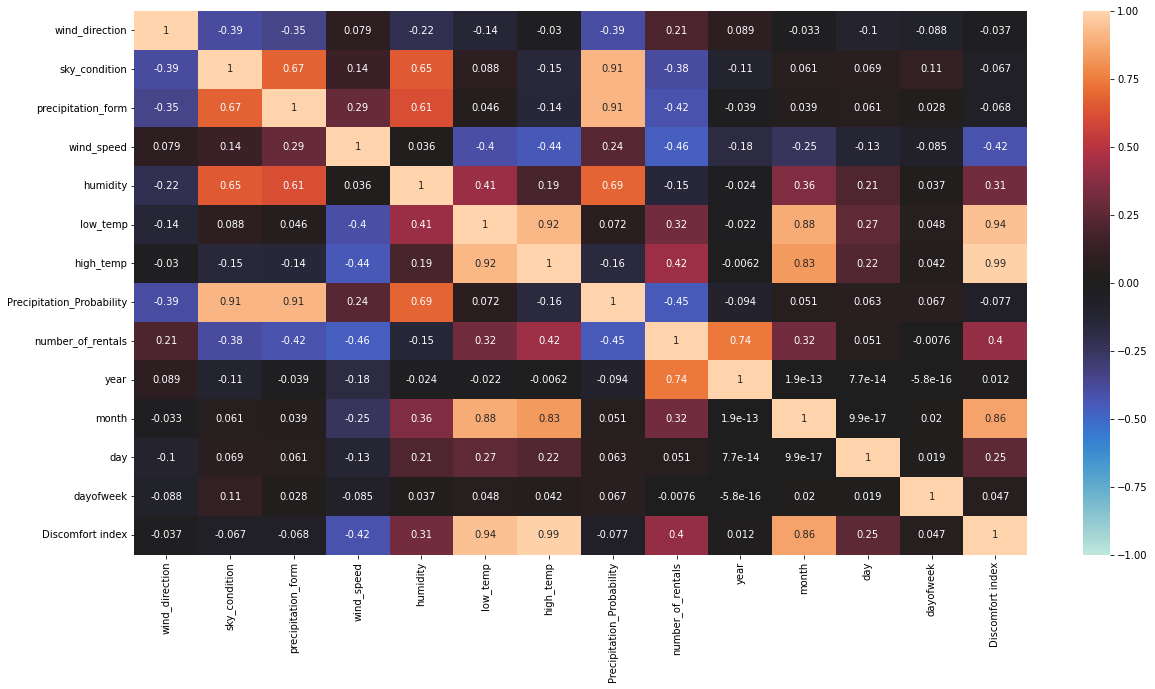

In [18]:
train_df_num = train_df.select_dtypes(np.number)
corr = train_df_num.corr()
plt.figure(figsize = (20, 10))
sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, annot=True)

high temp와 correlation값이 0.99 -> 다중공선성 문제로 제거

다중공선성 : 통계학의 회귀분석에서 독립변수들 간에 강한 상관관계가 나타나는 문제

In [19]:
train_df = train_df.drop('Discomfort index', axis = 1)

In [20]:
train_df = train_df.select_dtypes(np.number)

In [21]:
X = train_df[train_df.columns.difference(['number_of_rentals'])]
y = train_df['number_of_rentals']

In [22]:
test_df['date_time'] = pd.to_datetime(test_df['date_time'])
test_df['year'] = test_df['date_time'].dt.year
test_df['month'] = test_df['date_time'].dt.month
test_df['day'] = test_df['date_time'].dt.day
test_df['dayofweek'] = test_df.date_time.dt.dayofweek

In [23]:
test_df = test_df.select_dtypes(np.number)

## Modeling(Ridge, Lasso, ElasticNet)

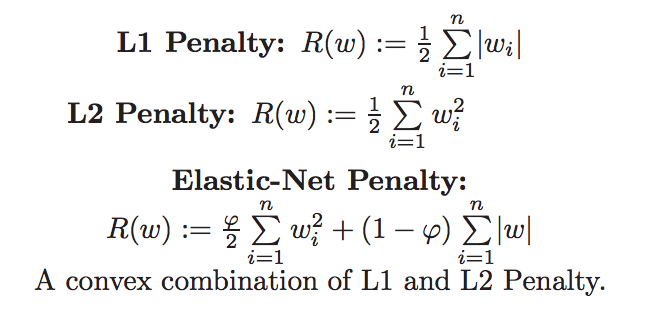

In [24]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

In [25]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [26]:
alpha = [0, 0.1, 1, 10, 100]
for i in alpha:
    ridge = Ridge(alpha = i)
    neg_mse = cross_val_score(ridge, X, y, scoring='neg_mean_squared_error', cv = 5)
    avg_mse = np.mean(np.sqrt(-1 * neg_mse))
    print('alpha {}, 5 fold mean RMSE : {}, total mse : {}'.format(i, avg_mse, neg_mse))

alpha 0, 5 fold mean RMSE : 13573.624461413405, total mse : [-1.78694193e+08 -1.26635867e+08 -2.01152279e+08 -1.22789577e+08
 -3.23400702e+08]
alpha 0.1, 5 fold mean RMSE : 13500.393030238814, total mse : [-1.77840074e+08 -1.22828893e+08 -2.01139405e+08 -1.22122294e+08
 -3.18630285e+08]
alpha 1, 5 fold mean RMSE : 13332.124916646917, total mse : [-1.68440708e+08 -1.19046177e+08 -2.01342168e+08 -1.20363855e+08
 -3.10139216e+08]
alpha 10, 5 fold mean RMSE : 12859.669372101942, total mse : [-1.20236001e+08 -1.37198768e+08 -2.02666299e+08 -1.13507552e+08
 -2.79888134e+08]
alpha 100, 5 fold mean RMSE : 17882.272888466392, total mse : [-3.73753222e+08 -3.63235236e+08 -2.06594367e+08 -1.94171838e+08
 -5.15834422e+08]


alpha 10일때 RMSE가 가장 낮음

In [24]:
X_test = test_df[test_df.columns.difference(['number_of_rental_predict'])]

In [28]:
ridge = Ridge(alpha = 10)
ridge.fit(X, y)
num_of_ren = ridge.predict(X_test)
test_df['number_of_rental_predict_ridge'] = num_of_ren

In [35]:
sub = pd.read_csv('sample_submission.csv')

In [30]:
sub['number_of_rentals'] = test_df['number_of_rental_predict_ridge']

In [31]:
sub.to_csv('ridge_submission.csv', index = False)

리더보드
평가 산식 : NMAE (Normalized Mean Absolute Error) 

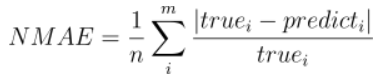

In [32]:
alpha = [0.07, 0.1, 0.5, 1, 3]
for i in alpha:
    lasso = Lasso(alpha = i)
    neg_mse = cross_val_score(lasso, X, y, scoring='neg_mean_squared_error', cv = 5)
    avg_mse = np.mean(np.sqrt(-1 * neg_mse))
    print('alpha {}, 5 fold mean RMSE : {}, total mse : {}'.format(i, avg_mse, neg_mse))

alpha 0.07, 5 fold mean RMSE : 13572.7981430655, total mse : [-1.78681349e+08 -1.26606834e+08 -2.01151518e+08 -1.22785122e+08
 -3.23323980e+08]
alpha 0.1, 5 fold mean RMSE : 13572.527783147936, total mse : [-1.78675846e+08 -1.26595212e+08 -2.01151198e+08 -1.22783438e+08
 -3.23304479e+08]
alpha 0.5, 5 fold mean RMSE : 13569.18571575582, total mse : [-1.78602625e+08 -1.26468771e+08 -2.01147087e+08 -1.22761082e+08
 -3.23045713e+08]
alpha 1, 5 fold mean RMSE : 13565.258423743804, total mse : [-1.78511481e+08 -1.26336101e+08 -2.01142337e+08 -1.22733412e+08
 -3.22725518e+08]
alpha 3, 5 fold mean RMSE : 13549.232492273242, total mse : [-1.78144655e+08 -1.25744327e+08 -2.01127870e+08 -1.22625777e+08
 -3.21481040e+08]


In [33]:
lasso = Lasso(alpha = 3)
lasso.fit(X, y)
num_of_ren = lasso.predict(X_test)
test_df['number_of_rental_predict_lasso'] = num_of_ren

In [34]:
sub['number_of_rentals'] = test_df['number_of_rental_predict_lasso']
sub.to_csv('lasso_submission.csv', index = False)

In [35]:
alpha = [0.07, 0.1, 0.5, 1, 3]
for i in alpha:
    elastic = ElasticNet(alpha = i, l1_ratio=0.7)
    neg_mse = cross_val_score(elastic, X, y, scoring='neg_mean_squared_error', cv = 5)
    avg_mse = np.mean(np.sqrt(-1 * neg_mse))
    print('alpha {}, 5 fold mean RMSE : {}, total mse : {}'.format(i, avg_mse, neg_mse))

alpha 0.07, 5 fold mean RMSE : 13034.42520273052, total mse : [-1.40393330e+08 -1.24940834e+08 -2.01912715e+08 -1.16636831e+08
 -2.93649714e+08]
alpha 0.1, 5 fold mean RMSE : 12939.837656627386, total mse : [-1.30662627e+08 -1.29150382e+08 -2.02198181e+08 -1.15201358e+08
 -2.87341408e+08]
alpha 0.5, 5 fold mean RMSE : 13737.834341033158, total mse : [-1.46553514e+08 -1.97348758e+08 -2.04700980e+08 -1.19624259e+08
 -2.98961145e+08]
alpha 1, 5 fold mean RMSE : 15922.014070135567, total mse : [-2.57069140e+08 -2.83613590e+08 -2.05948178e+08 -1.52628823e+08
 -4.01227540e+08]
alpha 3, 5 fold mean RMSE : 21403.229186736753, total mse : [-6.15085761e+08 -5.23356252e+08 -2.07760688e+08 -2.97730194e+08
 -7.65599927e+08]


In [36]:
elastic = ElasticNet(alpha = 0.1, l1_ratio=0.7)
elastic.fit(X, y)
num_of_ren = elastic.predict(X_test)
test_df['number_of_rental_predict_elastic'] = num_of_ren

In [37]:
sub['number_of_rentals'] = test_df['number_of_rental_predict_elastic']
sub.to_csv('elastic_submission.csv', index = False)

In [38]:
test_df

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,dayofweek,number_of_rental_predict_ridge,number_of_rental_predict_lasso,number_of_rental_predict_elastic
0,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,2021,4,1,3,93553.309649,96041.705326,94053.282547
1,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,2021,4,2,4,89378.058897,92927.967495,89910.486085
2,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2021,4,3,5,70542.447519,72205.584796,70890.426554
3,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,2021,4,4,6,72903.713155,73759.425125,73385.799446
4,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,2021,4,5,0,102997.365301,105204.719683,103390.668156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,177.149,3.980,0.223,1.066,74.628,20.312,28.579,36.486,2021,6,26,5,112107.043965,115528.191359,112718.737105
87,138.723,2.777,0.135,1.290,70.236,20.812,29.000,18.378,2021,6,27,6,118097.152014,120009.637050,118610.507605
88,111.095,3.338,1.270,1.692,70.338,21.000,28.789,35.946,2021,6,28,0,104744.707125,92456.130182,105148.650596
89,171.622,3.270,0.595,1.470,70.473,21.000,29.421,27.770,2021,6,29,1,114599.356245,110887.364260,115114.054944


In [29]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [38]:
xgb =XGBRegressor()

In [45]:
xgb_param_grid ={
    'max_depth' : [3,4,5,6] , 
    'n_estimators': [10, 50, 100], 
    'learning_rate':[0.01, 0.05], 
    'gamma': [ 0.1, 0.5, 1, 2]
}

In [46]:
xgb_grid_search = GridSearchCV(xgb, xgb_param_grid,  n_jobs = -1, verbose = 2)
xgb_grid_search.fit(X, y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[11:51:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'gamma': [0.1, 0.5, 1, 2],
                         'learning_rate': [0.01, 0.05],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [10, 50, 100]},
             verbose=2)

In [47]:
xgb_grid_search.best_params_

{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

In [48]:
num_of_ren_xgb = xgb_grid_search.best_estimator_.predict(X_test)

In [49]:
num_of_ren_xgb

array([ 75537.4  ,  72058.27 ,  27543.877,  42172.297,  76511.164,
        79261.17 ,  77321.18 ,  75876.37 ,  76510.15 ,  80226.51 ,
        74030.52 ,  31402.682,  60591.43 ,  73095.71 ,  71472.   ,
        55195.133,  55165.145,  78103.266,  86981.914,  89720.08 ,
        91185.71 ,  87971.26 ,  81598.59 ,  83419.16 ,  79018.375,
        80708.57 ,  75963.64 ,  73053.766,  75360.086,  58485.22 ,
        39482.56 ,  74540.71 ,  82396.26 ,  46897.992,  73532.32 ,
        81264.68 ,  66952.9  ,  80905.734,  79838.37 ,  71046.2  ,
        95694.27 ,  93958.83 ,  97934.78 ,  90147.805,  73025.95 ,
        31882.693,  69424.79 ,  92570.22 ,  93375.   ,  74054.18 ,
        56131.453,  94663.36 ,  92979.68 ,  92126.32 ,  78942.984,
        86501.67 ,  73302.64 ,  79337.2  ,  90405.2  ,  86931.61 ,
        61660.168,  90692.16 ,  95425.53 ,  56006.02 ,  94737.5  ,
        96783.76 ,  95723.36 ,  95725.59 ,  96299.27 ,  98249.805,
        95705.08 ,  58431.574, 102244.42 , 101089.68 , 102244.

In [50]:
sub['number_of_rentals'] = num_of_ren_xgb
sub.to_csv('xgb_submission.csv', index = False)